In [19]:
#Purpose: Extract EIS data from Scribner software for HFR data
#Author: Shan Kutagulla
#Organization: Univ. of Texas at Austin

In [20]:
#!pip3 install pandas
#!pip3 install fsspec
#!pip3 install smbprotocol
#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install openpyxl

In [21]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import openpyxl
import numpy as np
import scipy.signal

In [22]:
AREA=25; #in cm^2

In [23]:
#Administrative stuff, read in data and flip imaginary axis
filename="/Users/shanmukhkutagulla/My Drive/Fuel Cell Docs/EIS-GO_4pass_12172021.fcd"
data=pd.read_csv(filename, skiprows=41, delimiter="\t", usecols=["Z_Real (Ohm)","Z_Imag (Ohm)"])
data=data.drop(0,axis=0).reindex()
data["Z_Imag_Neg (Ohm)"]=data["Z_Imag (Ohm)"]*-1

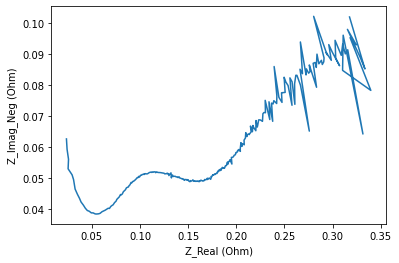

In [24]:
plt.plot(data["Z_Real (Ohm)"],data["Z_Imag_Neg (Ohm)"])
plt.xlabel("Z_Real (Ohm)");
plt.ylabel("Z_Imag_Neg (Ohm)");

In [25]:
#fit graph to polynomial and determine leftmost minima
def determine_eis_hfr(x_val,y_val,degree_N, area_active): #Use leftmost minima to determin HFR
    quadfit=np.polyfit(x_val,y_val,deg=degree_N) #fit curve to smooth
    y_fit=0
    for i in range(0,degree_N+1):
            y_fit=y_fit+quadfit[i]*x_val**((degree_N-i)) #develop points for fit
    plt.plot(data["Z_Real (Ohm)"],data["Z_Imag_Neg (Ohm)"]) #plot real
    plt.xlabel("Z_Real (Ohm)")
    plt.ylabel("Z_Imag_Neg (Ohm)")
    plt.plot(data["Z_Real (Ohm)"],y_fit) #Plot fit 
    
    index=scipy.signal.argrelmin(y_fit.values, order=3) #Use 3 points on either side to determine if minima or not
    minima_hfr=index[0][0] #obtain leftmost point
    x_hfr_val=x_val.iloc[minima_hfr]*area_active #multiply by active area of MEA
    y_hfr_val=y_val.iloc[minima_hfr]
    return x_hfr_val, y_hfr_val
    

The HFR for this MEA is: 1.3370250000000001 Ohms-cm^2
Standard Nafion HFR: 0.05 Ohms-cm^2
This MEA conducts at an efficiency of: 0.0373964585553748 in comparison to Nafion


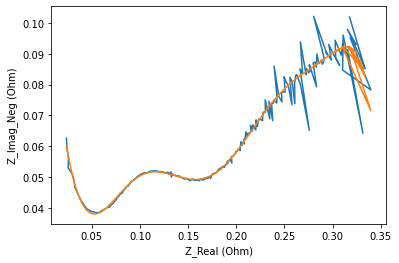

In [26]:
hfr_x, hfr_y=determine_eis_hfr(data["Z_Real (Ohm)"], data["Z_Imag_Neg (Ohm)"],degree_N=8, area_active=AREA) #Use an x^8 curve fir with an active area of 25 cm2
print("The HFR for this MEA is: "+ str(hfr_x) + " Ohms-cm^2")
print("Standard Nafion HFR: 0.05 Ohms-cm^2")
print("This MEA conducts at an efficiency of: " + str(0.05/hfr_x)+ " in comparison to Nafion")